In [448]:
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from PIL import Image
cudnn.benchmark = True
plt.ion()   # interactive mode

In [449]:
from loaders.data_loader import *
from trainers.trainer import *

In [450]:
batch_size = 16
num_workers = 1

# test data have not masks so we use validation set for tests
# img_dir_test = "data/Foot Ulcer Segmentation Challenge/test/images"
# mask_dir_test = "data/Foot Ulcer Segmentation Challenge/test/labels"

img_dir_test = "data/Foot Ulcer Segmentation Challenge/validation/images"
mask_dir_test = "data/Foot Ulcer Segmentation Challenge/validation/labels"

In [451]:
data_transforms = data_preprocessing_unet()
image_loader_test = ImageLoader(img_dir_test, mask_dir=mask_dir_test, image_tform=data_transforms['test'], mask_tform=data_transforms['test'], imgloader=PIL.Image.open)
dataset_test_size = len(image_loader_test)
dataloader_test = torch.utils.data.DataLoader(image_loader_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=num_workers)
print(dataset_test_size)

200


In [452]:
test_features, test_labels = next(iter(dataloader_test))
print(test_features.size())

torch.Size([16, 3, 256, 256])


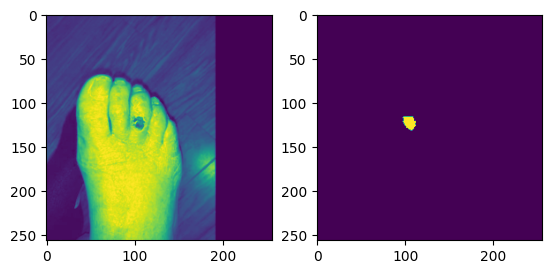

In [453]:
f, ax = plt.subplots(1,2)
ax[0].imshow(test_features[0][0])
ax[1].imshow(test_labels[0][0])

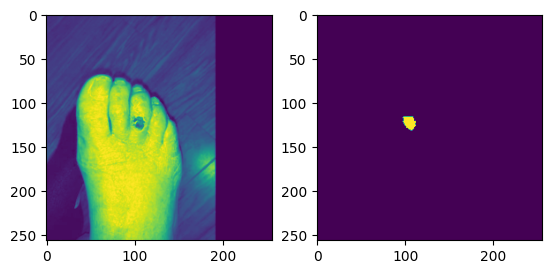

In [454]:
f, ax = plt.subplots(1,2)
ax[0].imshow(test_features[0][0])
ax[1].imshow(test_labels[0][0])

In [455]:
from models.tiny_unet import *
from models.unet_model_zoo import UNet, DeepLabV3, SSModelZoo
from models.LiteSeg import  LiteSeg

# model = LiteSeg(backbone_type='mobilenet_v2', name='LiteSeg')
# model = DeepLabV3(num_classes=2)
model = TinyUNet(in_channels=3, num_classes=2)
# # from models.unet_model_zoo import UNet
# model = UNet(pretrained=True, out_channels=2)


In [456]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Device is: {device}")

Device is: cuda:0


In [457]:
PATH = "ckpt/best_model_tinyunet_rgb_params.pt"
# PATH = "ckpt/best_model_UNet_weights_params.pt"
# PATH = "ckpt/my_model/best_model_UNet_gray_weights_params.pt"
model.load_state_dict(torch.load(PATH, map_location=device))
# model.load_state_dict(torch.load(PATH, weights_only=True, map_location=device))

# PATH = "ckpt/best_model_UNet_params_color.pt"
# model.load_state_dict(torch.load(PATH, weights_only=False, map_location=device))
model.eval()

TinyUNet(
  (encoder1): UNetEncoder(
    (cmrf): CMRF(
      (pwconv1): Conv(
        (conv): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(8, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): GELU()
      )
      (pwconv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): GELU()
      )
      (m): ModuleList(
        (0): DWConv(
          (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn): BatchNorm2d(4, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): Identity()
        )
        (1): DWConv(
          (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (bn): BatchNorm2d(4, eps=0.001, momentum=0.03, affine=True, track_running_stats

In [458]:
def infer(model, device, test_loader):
    
    results = []
    masks = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            results.append(outputs.cpu().detach().numpy())
            masks.append(labels.cpu().detach().numpy())
            
    return results, masks

In [459]:
res, masks_val = infer(model=model, device=device, test_loader=dataloader_test)

In [460]:
result_data = np.array(res)
masks_data = np.array(masks_val)

print(result_data.shape)

(12, 16, 2, 256, 256)


In [461]:
results = result_data.reshape(12 * 16, 2, 256, 256)
# we select class 1 - white is our mask
predicted_mask = results[:, 1, :, :]

results_masks = masks_data.reshape(12 * 16, 1, 256, 256)
true_mask = results_masks[:, 0, :, :]


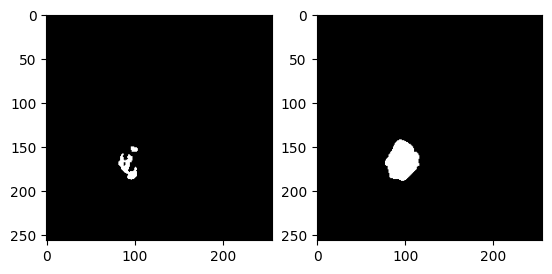

In [462]:
# show some examples
index = 2
threshold = 0.1

predicted_mask_binary = np.where(predicted_mask[index] < threshold, 0, 1)
true_mask_binary = np.where(true_mask[index] < threshold, 0, 1)

f, ax = plt.subplots(1,2)
ax[0].imshow(predicted_mask_binary, cmap='gray')
ax[1].imshow(true_mask_binary, cmap='gray')
plt.show()

In [463]:
def calculate_iou_dice(true_masks, predicted_masks):

    overlap = predicted_masks * true_masks    
    total_sum = predicted_masks + true_masks
    union = np.where(total_sum >= 1, 1, 0)
    iou = overlap.sum()/float(union.sum())
    dice = 2 * overlap.sum()/float(total_sum.sum())
    return np.mean(iou), np.mean(dice)

In [464]:
threshold = 0.01
predicted_mask_bin = np.where(predicted_mask < threshold, 0, 1)
true_mask_bin = np.where(true_mask < threshold, 0, 1)

iou, dice = calculate_iou_dice(true_mask_bin, predicted_mask_bin)
print('IoU:',iou)
print('Dice:',dice)

IoU: 0.5921331549092287
Dice: 0.7438236595770001


In [465]:
def best_threshold(debug=True):
    thresholds = [0.00000001, 0.0001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    threshold_best = 0
    max_iou = 0
    max_dice = 0
    for threshold in thresholds:
        predicted_mask_bin = np.where(predicted_mask < threshold, 0, 1)
        true_mask_bin = np.where(true_mask < threshold, 0, 1)  
        iou, dice = calculate_iou_dice(true_mask_bin, predicted_mask_bin)
        if iou > max_iou:
            max_iou = iou
            threshold_best = threshold
            if debug:
                print(f"Best threshold iou1: {threshold}, IoU: {iou}, Dice: {dice}")
        if dice > max_dice:
            max_dice = dice
            threshold_best = threshold
            if debug:
                print(f"Best threshold iou2: {threshold}, IoU: {iou}, Dice: {dice}")
    return threshold_best, max_iou, max_dice

In [466]:
best_threshold()
print(model.name)

Best threshold iou1: 1e-08, IoU: 0.5930620453066777, Dice: 0.7445561170123896
Best threshold iou2: 1e-08, IoU: 0.5930620453066777, Dice: 0.7445561170123896
tinyunet


In [467]:
import numpy as np
import cv2  # For image processing

# Load an RGB image (H x W x 3)
rgb_image = cv2.imread('image.jpg')  # Shape: (H, W, 3)

# Convert to grayscale (H x W)
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)  # Shape: (H, W)

# Stack the grayscale image 3 times along the channel axis (H x W x 3)
grayscale_3channel = np.stack([gray_image] * 3, axis=-1)  # Shape: (H, W, 3)

print(grayscale_3channel.shape)  # Output: (H, W, 3)

[ WARN:0@1766.308] global loadsave.cpp:268 findDecoder imread_('image.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [20]:
import torch

# Assume input_tensor is a PyTorch tensor with shape (H, W, 3)
input_tensor = torch.rand(256, 256, 3)  # Example tensor

# Convert to grayscale using the weighted sum formula
weights = torch.tensor([0.2989, 0.5870, 0.1140])  # Grayscale weights
gray_tensor = torch.tensordot(input_tensor, weights, dims=([-1], [0]))  # Shape: (H, W)

# Repeat the grayscale channel 3 times
grayscale_3channel_tensor = gray_tensor.unsqueeze(-1).repeat(1, 1, 3)  # Shape: (H, W, 3)

print(grayscale_3channel_tensor.shape)  # Output: (H, W, 3)


torch.Size([256, 256, 3])
